In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.experimental.numpy as tnp
import time,os, math
from multiprocessing import Process,Queue
from sympy import symbols, cos, sin, pi, simplify, pprint, tan, expand_trig, sqrt, trigsimp, atan2
from sympy.matrices import Matrix
import mpmath
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time,math
import os
from numpy import linalg
import cmath
import math
from math import cos as cos
from math import sin as sin
from math import atan2 as atan2
from math import acos as acos
from math import asin as asin
from math import sqrt as sqrt
from math import pi as pi
from numpy.linalg import norm
global mat
from sklearn.metrics import mean_squared_error
from random import *
import time
from sklearn.model_selection import train_test_split
import datetime as dt

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Activation,Layer
from tensorflow.keras.optimizers import Adamax,Adam, Nadam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Model, load_model, save_model
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Nadam
from tqdm import tqdm

mat=np.matrix

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
# Limit tensorflow to only allocate x GB of memory to the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    tf.config.experimental.set_virtual_device_configuration(
        gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=300)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:   
# The virtual device must be set at program startup
    print(e)

/home/irlab/anaconda3/envs/tf_py38/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [130]:
position_sample= np.array([[0.,0.,0.,0.,0.,0.]], dtype='float32')

In [ ]:
from tensorflow.keras.callbacks import Callback

# adapted from ReduceLROnPlateau
class RelativeReduceLROnPlateau(Callback):
    def __init__(self,
                 monitor='val_loss',
                 factor=0.1,
                 patience=10,
                 verbose=0,
                 alpha=0.01,
                 cooldown=0,
                 min_lr=0,
                 **kwargs):
        super(RelativeReduceLROnPlateau, self).__init__()

        self.monitor = monitor
        if factor >= 1.0:
            raise ValueError('RelativeReduceLROnPlateau ' 'does not support a factor >= 1.0.')
        self.factor = factor
        self.min_lr = min_lr
        self.alpha = alpha
        self.patience = patience
        self.verbose = verbose
        self.cooldown = cooldown
        self.cooldown_counter = 0  # Cooldown counter.
        self.wait = 0
        self.best = 0
        self.monitor_op = None
        self.mode = 'min'
        self._reset()

    def _reset(self):
        """Resets wait counter and cooldown counter.
        """
        if (self.mode == 'min' or
                (self.mode == 'auto' and 'acc' not in self.monitor)):
            self.monitor_op = lambda a, b: np.less(a, b*(1.-self.alpha))
            self.best = np.Inf
        else:
            raise Exception('Not implemented')
        self.cooldown_counter = 0
        self.wait = 0

    def on_train_begin(self, logs=None):
        self._reset()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        current = logs.get(self.monitor)
        if current is None:
            pass
        else:
            if self.in_cooldown():
                self.cooldown_counter -= 1
                self.wait = 0

            if self.monitor_op(current, self.best):
                self.best = current
                self.wait = 0
            elif not self.in_cooldown():
                self.wait += 1
                if self.wait >= self.patience:
                    old_lr = float(K.get_value(self.model.optimizer.lr))
                    if old_lr > self.min_lr:
                        new_lr = old_lr*self.factor
                        new_lr = max(new_lr, self.min_lr)
                        K.set_value(self.model.optimizer.lr, new_lr)
                        if self.verbose > 0:
                            print('\nEpoch %05d: RelativeReduceLROnPlateau reducing learning '
                                  'rate to %s.'%(epoch+1, new_lr))
                        self.cooldown_counter = self.cooldown
                        self.wait = 0

    def in_cooldown(self):
        return self.cooldown_counter > 0

# adapted from EarlyStopping
class RelativeEarlyStopping(Callback):
  def __init__(self,
               monitor='val_loss',
               alpha=0.0,
               patience=0,
               earliest_epoch=0,
               verbose=0):
    super(RelativeEarlyStopping, self).__init__()
    self.monitor = monitor
    self.patience = patience
    self.verbose = verbose
    self.alpha = abs(alpha)
    self.wait = 0
    self.stopped_epoch = 0
    self.earliest_epcoh=earliest_epoch
    self.monitor_op = lambda a, b: np.less(a, b*(1.-self.alpha))


  def on_train_begin(self, logs=None):
    # Allow instances to be re-used
    self.wait = 0
    self.stopped_epoch = 0
    self.best = np.Inf

  def on_epoch_end(self, epoch, logs=None):
    current = self.get_monitor_value(logs)
    if current is None:
      return
    if self.monitor_op(current, self.best):
      self.best = current
      self.wait = 0
    else:
      self.wait += 1
      if epoch>=self.earliest_epcoh and self.wait >= self.patience:
        self.stopped_epoch = epoch
        self.model.stop_training = True

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0 and self.verbose > 0:
      print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))

  def get_monitor_value(self, logs):
    logs = logs or {}
    monitor_value = logs.get(self.monitor)
    return monitor_value

class EarlyStoppingWMinEpoch(Callback):
  def __init__(self,
               monitor='val_loss',
               min_delta=0,
               patience=0,
               verbose=0,
               mode='auto',
               baseline=None,
               restore_best_weights=False,
               earliest_epoch=0):
    super(EarlyStoppingWMinEpoch, self).__init__()

    self.monitor = monitor
    self.patience = patience
    self.verbose = verbose
    self.baseline = baseline
    self.min_delta = abs(min_delta)
    self.wait = 0
    self.stopped_epoch = 0
    self.restore_best_weights = restore_best_weights
    self.best_weights = None
    self.earliest_epoch = earliest_epoch

    if mode not in ['auto', 'min', 'max']:
      mode = 'auto'

    if mode == 'min':
      self.monitor_op = np.less
    elif mode == 'max':
      self.monitor_op = np.greater
    else:
      if 'acc' in self.monitor:
        self.monitor_op = np.greater
      else:
        self.monitor_op = np.less

    if self.monitor_op == np.greater:
      self.min_delta *= 1
    else:
      self.min_delta *= -1

  def on_train_begin(self, logs=None):
    # Allow instances to be re-used
    self.wait = 0
    self.stopped_epoch = 0
    if self.baseline is not None:
      self.best = self.baseline
    else:
      self.best = np.Inf if self.monitor_op == np.less else -np.Inf
    self.best_weights = None

  def on_epoch_end(self, epoch, logs=None):
    current = self.get_monitor_value(logs)
    if current is None:
      return
    if self.monitor_op(current - self.min_delta, self.best):
      self.best = current
      self.wait = 0
      if self.restore_best_weights:
        self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if epoch>=self.earliest_epoch and self.wait >= self.patience:
        self.stopped_epoch = epoch
        self.model.stop_training = True
        if self.restore_best_weights:
          if self.verbose > 0:
            print('Restoring model weights from the end of the best epoch.')
          self.model.set_weights(self.best_weights)

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0 and self.verbose > 0:
      print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))

  def get_monitor_value(self, logs):
    logs = logs or {}
    monitor_value = logs.get(self.monitor)
    return monitor_value


In [ ]:
class UR3_DNN:
    def __init__(self,bs):
        self.batch_size = bs

        self.d1 = 0.1519 # unit : [m]
        self.a2 = -0.24365
        self.a3 = -0.213258
        self.d4 = 0.11235
        self.d5 = 0.08535
        self.d6 = 0.0819
        
        self.d = mat([0.1519, 0,0 ,0.11235,0.08535,0.0819]) #ur3 m
        self.a =mat([0 ,-0.24365 ,-0.21325 ,0 ,0 ,0]) #ur3 cm
        self.alpha = mat([pi/2, 0, 0, pi/2, -pi/2, 0 ]) # ur3 rad
        
        self.position_data = np.array([[0,0,0,0,0,0,0]])  #  input data :  x,y,z,a,b,g,conf
        self.th_data = np.array([[0,0,0,0,0,0]])          #  output data : th1~th6
        self.th_sample = np.array([[0,0,0,0,0,0]])          #  output data : th1~th6
        self.position_sample= np.array([[0.,0.,0.,0.,0.,0.]], dtype='float32')

        self.identity_flattened = tf.repeat(tf.reshape(tf.eye(4), (1, 16)), self.batch_size, 0) 
        
        self.zeros = tf.repeat(tf.reshape(0., (1)), self.batch_size, 0) 
        self.ones = tf.repeat(tf.reshape(1., (1)), self.batch_size, 0) 
        self.pi_2 = tf.repeat(tf.reshape(pi/2, (1)), self.batch_size, 0) 
        
        self.d1_batch = tf.repeat([self.d1], self.batch_size,0)
        self.a2_batch = tf.repeat([self.a2], self.batch_size,0)
        self.a3_batch = tf.repeat([self.a3], self.batch_size,0)
        self.d4_batch = tf.repeat([self.d4], self.batch_size,0)
        self.d5_batch = tf.repeat([self.d5], self.batch_size,0)
        self.d6_batch = tf.repeat([self.d6], self.batch_size,0)
        
        self.d_ = [self.d1_batch, self.zeros,self.zeros ,self.d4_batch,self.d5_batch,self.d6_batch] #ur3 m
        self.a_ =[self.zeros ,self.a2_batch ,self.a3_batch ,self.zeros ,self.zeros ,self.zeros] #ur3 cm
        self.alpha_ = [self.pi_2, self.zeros, self.zeros, self.pi_2, -self.pi_2, self.zeros] # ur3 rad
        
    def RMSE(self,a,b):
        return mean_squared_error(a,b)**0.5

    # ***************************** FORWARD KINEMATICS
    def AH(self, n,th,c  ):

        T_a = mat(np.identity(4), copy=False)
        T_a[0,3] = self.a[0,n-1]
        T_d = mat(np.identity(4), copy=False)
        T_d[2,3] = self.d[0,n-1]

        Rzt = mat([[cos(th[n-1,c]), -sin(th[n-1,c]), 0 ,0],
                [sin(th[n-1,c]),  cos(th[n-1,c]), 0, 0],
                [0,               0,              1, 0],
                [0,               0,              0, 1]],copy=False)


        Rxa = mat([[1, 0,                 0,                  0],
                 [0, cos(self.alpha[0,n-1]), -sin(self.alpha[0,n-1]),   0],
                 [0, sin(self.alpha[0,n-1]),  cos(self.alpha[0,n-1]),   0],
                 [0, 0,                 0,                  1]],copy=False)

        A_i = T_d * Rzt * T_a * Rxa
        return A_i
    
    
    def HTrans(self,th,c ):  
        A_1=self.AH( 1,th,c  )
        A_2=self.AH( 2,th,c  )
        A_3=self.AH( 3,th,c  )
        A_4=self.AH( 4,th,c  )
        A_5=self.AH( 5,th,c  )
        A_6=self.AH( 6,th,c  )
      
        T_06=A_1*A_2*A_3*A_4*A_5*A_6

        return T_06
    #####################################################################################
    #tensor로 들어가도록 구현, error 구하고 array size가 [:,6] 형태로 들어가게함
    
    #tf 가능한 정기구학 gkat함수구현
    def AH_tf(self,n,th):   

        s_t = tf.sin(th[:,n-1])
        c_t = tf.cos(th[:,n-1])
        
        s_a = tf.sin(self.alpha_[n-1])
        c_a = tf.cos(self.alpha_[n-1])
        
        s_t = tf.cast(s_t,tf.float32)
        c_t = tf.cast(c_t,tf.float32)

        #A_i = [c_t, -c_a*s_t, s_a*s_t,l*c_t,
        #      s_t, c_a*c_t, -s_a*c_t, l*s_t,
        #      0, s_a, c_a, d
        #      0, 0, 0, 1]
        A_ = [c_t, -c_a*s_t, s_a*s_t, self.a_[n-1]*c_t,
              s_t, c_a*c_t, -s_a*c_t, self.a_[n-1]*s_t,
              self.zeros, s_a, c_a, self.d_[n-1],
              self.zeros,self.zeros,self.zeros,self.ones]
        A_ = tf.reshape(tf.stack(A_, axis=1), (self.batch_size, 4, 4))
        return A_

    def HTrans_tf(self,th ):  
        self.identity_flattened = tf.repeat(tf.reshape(tf.eye(4), (1, 16)), self.batch_size, 0) 
        
        self.zeros = tf.repeat(tf.reshape(0., (1)), self.batch_size, 0) 
        self.ones = tf.repeat(tf.reshape(1., (1)), self.batch_size, 0) 
        self.pi_2 = tf.repeat(tf.reshape(pi/2, (1)), self.batch_size, 0) 
        
        self.d1_batch = tf.repeat([self.d1], self.batch_size,0)
        self.a2_batch = tf.repeat([self.a2], self.batch_size,0)
        self.a3_batch = tf.repeat([self.a3], self.batch_size,0)
        self.d4_batch = tf.repeat([self.d4], self.batch_size,0)
        self.d5_batch = tf.repeat([self.d5], self.batch_size,0)
        self.d6_batch = tf.repeat([self.d6], self.batch_size,0)
        
        self.d_ = [self.d1_batch, self.zeros,self.zeros ,self.d4_batch,self.d5_batch,self.d6_batch] #ur3 m
        self.a_ =[self.zeros ,self.a2_batch ,self.a3_batch ,self.zeros ,self.zeros ,self.zeros] #ur3 cm
        self.alpha_ = [self.pi_2, self.zeros, self.zeros, self.pi_2, -self.pi_2, self.zeros] # ur3 rad
        
        #th= tf.convert_to_tensor(th)
        #th= tf.transpose(th)
        A_1=self.AH_tf( 1,th )
        A_2=self.AH_tf( 2,th )
        A_3=self.AH_tf( 3,th )
        A_4=self.AH_tf( 4,th )
        A_5=self.AH_tf( 5,th )
        A_6=self.AH_tf( 6,th )
    
        A_ = tf.matmul(A_1,A_2)
        A_ = tf.matmul(A_,A_3)
        A_ = tf.matmul(A_,A_4)
        A_ = tf.matmul(A_,A_5)
        A_ = tf.matmul(A_,A_6)

        return A_
    # ************************************************** INVERSE KINEMATICS 
    def invKine(self,desired_pos):# T60
        th = mat(np.zeros((6, 8)))
        conf = mat(np.zeros((3,8)))
        P_05 = (desired_pos * mat([0,0, -self.d6, 1]).T-mat([0,0,0,1 ]).T)
  
        # **** theta1 ****
  
        psi = atan2(P_05[2-1,0], P_05[1-1,0])
    
        phi = acos(self.d4 /sqrt(P_05[2-1,0]*P_05[2-1,0] + P_05[1-1,0]*P_05[1-1,0]))
        #The two solutions for theta1 correspond to the shoulder
        #being either left or right
        th[0, 0:4] = pi/2 + psi + phi
        th[0, 4:8] = pi/2 + psi - phi
        th = th.real
  
        # **** theta5 ****
  
        cl = [0, 4]# wrist up or down
        for i in range(0,len(cl)):
            c = cl[i]
            T_10 = linalg.inv(self.AH(1,th,c))
            T_16 = T_10 * desired_pos
            th[4, c:c+2] = + acos((T_16[2,3]-self.d4)/self.d6);
            th[4, c+2:c+4] = - acos((T_16[2,3]-self.d4)/self.d6);

        th = th.real
        
        # **** theta6 ****
        # theta6 is not well-defined when sin(theta5) = 0 or when T16(1,3), T16(2,3) = 0.

        cl = [0, 2, 4, 6]
        for i in range(0,len(cl)):
            c = cl[i]
            T_10 = linalg.inv(self.AH(1,th,c))
            T_16 = linalg.inv( T_10 * desired_pos )
            th[5, c:c+2] = atan2((-T_16[1,2]/sin(th[4, c])),(T_16[0,2]/sin(th[4, c])))
  
        th = th.real

        # **** theta3 ****
        cl = [0, 2, 4, 6]
        for i in range(0,len(cl)):
	        c = cl[i]
	        T_10 = linalg.inv(self.AH(1,th,c))
	        T_65 = self.AH( 6,th,c)
	        T_54 = self.AH( 5,th,c)
	        T_14 = ( T_10 * desired_pos) * linalg.inv(T_54 * T_65)
	        P_13 = T_14 * mat([0, -self.d4, 0, 1]).T - mat([0,0,0,1]).T
	        t3 = cmath.acos((linalg.norm(P_13)**2 - self.a2**2 - self.a3**2 )/(2 * self.a2 * self.a3)) # norm ?
	        th[2, c] = t3.real
	        th[2, c+1] = -t3.real

        # **** theta2 and theta 4 ****

        cl = [0, 1, 2, 3, 4, 5, 6, 7]
        for i in range(0,len(cl)):
	        c = cl[i]
	        T_10 = linalg.inv(self.AH( 1,th,c ))
	        T_65 = linalg.inv(self.AH( 6,th,c))
	        T_54 = linalg.inv(self.AH( 5,th,c))
	        T_14 = (T_10 * desired_pos) * T_65 * T_54
	        P_13 = T_14 * mat([0, -self.d4, 0, 1]).T - mat([0,0,0,1]).T
	      
	        # theta 2
	        th[1, c] = -atan2(P_13[1], -P_13[0]) + asin(self.a3* sin(th[2,c])/linalg.norm(P_13))
	        # theta 4
	        T_32 = linalg.inv(self.AH( 3,th,c))
	        T_21 = linalg.inv(self.AH( 2,th,c))
	        T_34 = T_32 * T_21 * T_14
	        th[3, c] = atan2(T_34[1,0], T_34[0,0])
        th = th.real

        return th

    def cos_sim(self,A, B):   # Check for similarity
        return np.dot(A, B)/(norm(A)*norm(B))
    
    def get_pos(self,p):
        # p : position 1x6 array
        a= round(p[3],5)
        b=round(p[4],5)
        g=round(p[5],5)
        x_=round(p[0],5)
        y_=round(p[1],5)
        z_=round(p[2],5)
        return mat([[cos(a)*cos(b)*cos(g) - sin(a)*sin(g) ,-cos(a)*sin(b),cos(g)*sin(a) + cos(a)*cos(b)*sin(g),x_],
                    [cos(g)*sin(b),                          cos(b),        sin(b)*sin(g),                       y_],
                    [-cos(a)*sin(g) - cos(b)*cos(g)*sin(a),sin(a)*sin(b), cos(a)*cos(g) - cos(b)*sin(a)*sin(g), z_],
                    [0,0,0,1]])
    
    def get_position(self,p):
        # p : N x 4 x 4  tensor
        x = p[:,0,3]
        y = p[:,1,3]
        z = p[:,2,3]
        
        cos = p[:,1,1]
        
        sin = tf.sqrt(1-tf.math.square(cos))
        b = tf.where(p[:,1,1]>=0, tf.math.atan2(sin,cos), tf.math.atan2(-sin,cos))
        a = tf.atan2(p[:,2,1],-p[:,0,1])
        g = tf.atan2(p[:,1,2],p[:,1,0])
        
        pos_ = np.array([x,y,z,a,b,g])
        pos_= pos_.T
        pos_ = tf.convert_to_tensor(
            pos_, dtype=None, dtype_hint=None, name=None
        )
    
    def data_sample(self,n):
        inv_th1 = 0
        data_cnt = 0
        pass_cnt = 0 
        t = time.time()
        position_sample = np.array([[0,0,0,0,0,0,0]])  #  input data :  x,y,z,a,b,g,conf
        th_sample = np.array([[0,0,0,0,0,0]])          #  output data : th1~th6
        
        with tqdm(total= n) as pbar:
            while (data_cnt<=n):
                x = uniform(-0.5,0.5)
                y = uniform(-0.5,0.5)    
                z = uniform(-0.2,0.5)
                alpha_ = uniform(-math.pi,math.pi)
                beta_ = uniform(-math.pi,math.pi)
                gamma_ = uniform(-math.pi,math.pi)
                r = sqrt(x**2+y**2+z**2)
                if r<0.5 and r>0.2:
                    pos = [x,y,z,alpha_,beta_,gamma_]
                    pos_1=self.get_pos(pos)
                    try:
                        inv_th1 = self.invKine(pos_1)
                    except:
                        pass
                    inv_pos1_2 = self.HTrans(inv_th1,0) 
                    error = round(self.RMSE(pos_1.tolist(),inv_pos1_2.tolist()),6)
                    if (2e-06 >=error):
                        data_cnt += 1

                        is_there_minus = inv_th1[0,:] < 0 
                        is_there_plus = inv_th1[0,:] > 0 

                        # if th1 is all negative; Check for amniotic fluid If yes ? pass, correct if not
                        if not(True in is_there_plus):
                            min_th1 = min(inv_th1[0,0],inv_th1[0,4])
                            if inv_th1[0,0]==min_th1:
                                inv_th1[0,:4] += 2*math.pi 
                            else:
                                inv_th1[0,4:] += 2*math.pi 

                        # if th1 is all positive; Check for negative numbers If yes ? pass, correct if not
                        if not(True in is_there_minus):
                            max_th1 = max(inv_th1[0,0],inv_th1[0,4])
                            if inv_th1[0,0]==max_th1:
                                inv_th1[0,:4] -= 2*math.pi 
                            else:
                                inv_th1[0,4:] -= 2*math.pi 

                        pos_conf = np.hstack([pos,0])
                        #pos_conf[3:6]*=10
                        for i in range(8):
                            conf = 0
                            th_tem = inv_th1[:,i].T
                            th_tem = th_tem.tolist()[0]
                            if th_tem[2] == 0:
                                continue
                            if (th_tem[0] >= 0 and th_tem[2] >= 0 and th_tem[4] >= 0):
                                conf = 80
                            elif (th_tem[0] >= 0 and th_tem[2] >= 0 and th_tem[4] < 0):
                                conf = 70
                            elif (th_tem[0] >= 0 and th_tem[2] < 0 and th_tem[4] >= 0):
                                conf = 60
                            elif (th_tem[0] >= 0 and th_tem[2] < 0 and th_tem[4] < 0):
                                conf = 50
                            elif (th_tem[0] < 0 and th_tem[2] >= 0 and th_tem[4] >= 0):
                                conf = 40
                            elif (th_tem[0] < 0 and th_tem[2] >= 0 and th_tem[4] < 0):
                                conf = 30
                            elif (th_tem[0] < 0 and th_tem[2] < 0 and th_tem[4] >= 0):
                                conf = 20
                            elif (th_tem[0] < 0 and th_tem[2] < 0 and th_tem[4] < 0):
                                conf = 10
                            pos_conf[6] = conf
                            position_sample = np.vstack([position_sample,pos_conf])
                            th_sample = np.vstack([th_sample,th_tem])
                        pass_cnt += 1
                        pbar.update(1)
                    else:
                        pass
                else:        
                    continue
        self.position_data = np.vstack([self.position_data,position_sample[1:]])
        self.th_data = np.vstack([self.th_data,th_sample[1:]])
        for i in range(2):
            self.th_data[:,i] = np.where(self.th_data[:,i]>pi, self.th_data[:,i]-2*pi , self.th_data[:,i])
            self.th_data[:,i] = np.where(self.th_data[:,i]<-pi, self.th_data[:,i]+2*pi , self.th_data[:,i])
        
        #self.th_data = np.where(self.th_data<0, self.th_data+2*pi , self.th_data)
        #self.position_data[:,3:6] = np.where(self.position_data[:,3:6]<0,self.position_data[:,3:6] + 2*pi, self.position_data[:,3:6])
        print("time : ",time.time()-t)
        print("pass : ",pass_cnt)
        print("data : ",data_cnt)
        
    def data_sample_ths(self,n):
        inv_th1 = 0
        data_cnt = 0
        pass_cnt = 0 
        t = time.time()
        sample = np.array([[0.,0.,0.,0.,0.,0.]], dtype='float32')
        with tqdm(total= n) as pbar:
            while(data_cnt < n):
                th1 = uniform(-math.pi,math.pi)
                th2 = uniform(-math.pi,math.pi)
                th3 = uniform(-math.pi,math.pi)
                th4 = uniform(-math.pi,math.pi)
                th5 = uniform(-math.pi,math.pi)
                th6 = uniform(-math.pi,math.pi)
                th = [th1,th2,th3,th4,th5,th6]

                sample = np.vstack([sample,th])
                pbar.update(1)
                data_cnt += 1
        self.th_sample = np.vstack([sample[1:],self.th_sample[1:]])
        
        
        
        
        print("time : ",time.time()-t)
        print("pass : ",pass_cnt)
        print("data : ",data_cnt)
        
    def get_position(self,p,output_):
        # N x 4 x 4   Tensor pos
        # N x 6  Tensor ths
        x = p[:,0,3]
        y = p[:,1,3]
        z = p[:,2,3]
        
        cos = p[:,1,1]
        
        sin = tf.sqrt(1-tf.math.square(cos))
        b = tf.where(p[:,1,1]>=0, tf.math.atan2(sin,cos), tf.math.atan2(-sin,cos))
        a = tf.atan2(p[:,2,1],-p[:,0,1])
        g = tf.atan2(p[:,1,2],p[:,1,0])
        
        conf= x
        
        conf = conf.numpy()
        
        output = output_.numpy()
        
        conf[np.where((output[:,0]>0) & (output[:,2]>0) & (output[:,4]>0))] = 80
        conf[np.where((output[:,0]>0) & (output[:,2]>0) & (output[:,4]<0))] = 70
        conf[np.where((output[:,0]>0) & (output[:,2]<0) & (output[:,4]>0))] = 60
        conf[np.where((output[:,0]>0) & (output[:,2]<0) & (output[:,4]<0))] = 50
        conf[np.where((output[:,0]<0) & (output[:,2]>0) & (output[:,4]>0))] = 40
        conf[np.where((output[:,0]<0) & (output[:,2]>0) & (output[:,4]<0))] = 30
        conf[np.where((output[:,0]<0) & (output[:,2]<0) & (output[:,4]>0))] = 20
        conf[np.where((output[:,0]<0) & (output[:,2]<0) & (output[:,4]<0))] = 10
        
        pos_ = np.array([x,y,z,a,b,g,conf])
        pos_= pos_.T
        pos_ = tf.convert_to_tensor(
            pos_, dtype=None, dtype_hint=None, name=None
        )

        
        return pos_

    def data_split(self,data_y,data):
        x_train, x_test, y_train, y_test = train_test_split(data_y, data, test_size=0.2, shuffle=True)#데이터셋 전처리
        x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, shuffle=True)#데이터셋 전처리
        return x_train,y_train,x_test,y_test,x_valid,y_valid


    def filter_data(self,ths,pos):
        
        r = tf.math.sqrt(tf.square(robot.position_data[:,0])+tf.square(robot.position_data[:,1])+tf.square(robot.position_data[:,2]))
        r = r.numpy()
        
        ths = ths.numpy()
        pos = pos.numpy()

        
        
        pos = pos[np.where((r<0.5) & (r>0.2) )]
        ths = ths[np.where((r<0.5) & (r>0.2) )]
        
        ths = ths[np.where(pos[:,2]>0)]
        pos = pos[np.where(pos[:,2]>0)]

        ths = np.where(ths<0, ths+2*pi , ths)
        
        for i in range(3,6):
            pos[:,i] = np.where(pos[:,i]<0,pos[:,i] + 2*pi, pos[:,i])
        
        ths= tf.convert_to_tensor(ths)
        pos= tf.convert_to_tensor(pos)


        return ths,pos
        
class DNN_model(Model):
    def __init__(self,num_layers, num_node,activation=0,initializer=0,batch_size=500):
        super(DNN_model, self).__init__()
        self.num_layers = num_layers
        self.num_node = num_node
        self.batch_size = batch_size
        self.input_size = 7
        self.output_size = 6
        
        activation_name = ['mish','lisht', 'relu', 'tanh'][activation]
        activation = [tfa.activations.mish, tfa.activations.lisht, tf.nn.relu, tf.nn.tanh][activation]
        initializer_name = ['random_normal','he_normal','orthogonal','Glorot'][initializer]
        initializer = [tf.keras.initializers.RandomNormal(), tf.keras.initializers.HeNormal(), tf.keras.initializers.Orthogonal(), tf.keras.initializers.GlorotNormal()][initializer] 
        
        self.activation = activation
        self.initializer = initializer
        
        x = dt.datetime.now()
        date = 'd{}_{}_{}'.format(x.year,x.month,x.day)

        self.model_name = 'DNN_IK_{num_layer}_{num_node}_{activ}_{initial}_{bs}'.format(num_layer = num_layers,num_node = num_node, activ = activation_name,initial=initializer_name,bs =self.batch_size) 
        self.model_name = self.model_name+ '_adamw'
        #self.model_name = self.model_name 
        
        self.log_dir = "logs/" + self.model_name + '_' + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=self.log_dir)
        
        self.val_loss_name = os.path.join('checkpoint', self.model_name,'val_loss',"{name}_loss.h5".format(name=self.model_name))
        self.val_loss_name_fast = os.path.join('checkpoint', self.model_name,'val_loss',"{name}_fast_loss.h5".format(name=self.model_name))

        self.val_1mm_name = os.path.join('checkpoint', self.model_name,'val_1mm_above',"{name}_1mm.h5".format(name=self.model_name))
        self.val_1cm_name = os.path.join('checkpoint', self.model_name,'val_1cm_above',"{name}_1cm.h5".format(name=self.model_name))

        self.val_loss_chkpt = tf.keras.callbacks.ModelCheckpoint(self.val_loss_name,
                                                                monitor='val_loss', save_best_only=True, verbose=False)
        self.val_loss_fast_chkpt = tf.keras.callbacks.ModelCheckpoint(self.val_loss_name_fast,
                                                                monitor='val_loss', save_best_only=True, verbose=False)
        self.val_1cm_chkpt = tf.keras.callbacks.ModelCheckpoint(self.val_1cm_name,
                                                               monitor='val_fk_above_1cm_dist', save_best_only=True, verbose=False)
        self.val_1mm_chkpt = tf.keras.callbacks.ModelCheckpoint(self.val_1mm_name,
                                                               monitor='val_fk_above_1mm_dist', save_best_only=True, verbose=False)
        
        self.lr_init = 1e-2
        self.lr_callback = tf.keras.callbacks.LearningRateScheduler(self.scheduler)
        ### Optimizer ###
        self.opt = tf.keras.optimizers.Nadam(learning_rate=self.lr_init)
        self.wd = 1e-4
        self.early_stopping =EarlyStoppingWMinEpoch(monitor='val_fk_mean_dist', min_delta=0.05, patience=110, mode='min', earliest_epoch=750)
    
    
    def make_model(self):
        self.lr_callback = tf.keras.callbacks.LearningRateScheduler(self.scheduler)
        input_= Input(shape=self.input_size)
        A = input_
        for i in range(self.num_layers):
            A = Dense(self.num_node, name='layer{}'.format(i+1), kernel_initializer = self.initializer)(A)
            A = self.activation(A)
            A = tf.keras.layers.BatchNormalization()(A)
        
        output_ = Dense(self.output_size, activation='linear', name='Outputs')(A)

        self.model = Model(inputs= input_ , outputs = output_)
        
        
        
        self.model.summary()
        
    
    def get_weight_set_weight(self,name):
        trained_model = tf.keras.models.load_model(name,compile = False)
        a = trained_model.get_weights()
        self.model.set_weights(a)
    

    def scheduler(self,epoch, lr):
        lr_ = lr*tf.math.exp(-0.1*epoch/50000)
        self.wd = lr_*1e-2
        print(lr_)
        
        if lr_> 1e-5:
            return lr_
        else:
            return 1e-5
        

    def fk_mean_dist(self,ans,pred):
        pred *= (2*pi)
        ans *= (2*pi)
        
        pred = tf.convert_to_tensor(pred)
        ans = tf.cast(ans, pred.dtype)
        pred_fk = robot.HTrans_tf(pred)
        ans_fk = robot.HTrans_tf(ans)
        dist = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(ans_fk,pred_fk)),axis=1))[:,3]
        return tf.reduce_sum(dist)

    def fk_above_1cm_dist(self,ans,pred):
        pred *= (2*pi)
        ans *= (2*pi)
        pred = tf.convert_to_tensor(pred)
        ans = tf.cast(ans, pred.dtype)

        pred_fk = robot.HTrans_tf(pred)
        ans_fk = robot.HTrans_tf(ans)
        dist = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(ans_fk,pred_fk)),axis=1))[:,3]
        above_1cm = tf.reduce_sum(tf.cast(dist>1.e-2, tf.float32))
        return above_1cm/(self.batch_size)*100


    def fk_above_1mm_dist(self,ans,pred):
        pred *= (2*pi)
        ans *= (2*pi)
        pred = tf.convert_to_tensor(pred)
        ans = tf.cast(ans, pred.dtype)
        pred_fk = robot.HTrans_tf(pred)
        ans_fk = robot.HTrans_tf(ans)

        dist = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(ans_fk,pred_fk)),axis=1))[:,3]
        above_1mm = tf.reduce_sum(tf.cast(dist>1.e-3, tf.float32))

        return above_1mm/(self.batch_size)*100

    def fit(self,train_x,train_y,batch_size,x_valid,y_valid):
        #self.opt = tf.keras.optimizers.Nadam(learning_rate=self.lr_init)
        self.opt = tf.keras.optimizers.Nadam(learning_rate=self.lr_init)
        self.model.compile(optimizer = self.opt,
                          loss = 'mse',
                          metrics = [tf.keras.metrics.MeanAbsoluteError(), self.fk_above_1mm_dist,self.fk_above_1cm_dist,self.fk_mean_dist  ],
                          run_eagerly=True     )
        
        step_per_epoch = len(x_train)//batch_size
        validation_steps = len(x_valid)//batch_size
        self.model.fit(train_x,train_y,
                              batch_size = batch_size,
                              epochs = epoch,
                              validation_data=(x_valid,y_valid),
                              steps_per_epoch = step_per_epoch,
                              validation_steps = validation_steps,
                              callbacks = [ self.lr_callback,
                                           self.tensorboard_callback,
                                           self.early_stopping,    
                                           self.val_1mm_chkpt,self.val_1cm_chkpt,self.val_loss_chkpt])
        
        
    def fit_fast(self,train_x,train_y,batch_size,x_valid,y_valid):
        
        self.opt = tf.keras.optimizers.Nadam(learning_rate=self.lr_init)
        
        self.opt_adamw = tfa.optimizers.AdamW(learning_rate = self.lr_init, weight_decay = self.wd)
        
        self.model_name = self.model_name+ '_adamw'
        self.model_name = self.model_name
        
        self.model.compile(optimizer = self.opt_adamw,
                          loss = 'mse',
                          metrics = [tf.keras.metrics.MeanAbsoluteError()],
                             )
        #run_eagerly=True  
        step_per_epoch = len(x_train)//batch_size
        validation_steps = len(x_valid)//batch_size
        self.model.fit(train_x,train_y,
                              batch_size = batch_size,
                              epochs = epoch,
                              validation_data=(x_valid,y_valid),
                              steps_per_epoch = step_per_epoch,
                              validation_steps = validation_steps,
                              callbacks = [self.lr_callback,
                                           self.tensorboard_callback,
                                           self.val_loss_fast_chkpt])
#robot = UR3_DNN(500)
#robot_model = DNN_model(4,128,0,3)
#robot_model.make_model()

epoch = 10000

In [28]:
robot = UR3_DNN(500)
robot.data_sample_2(10)

100%|██████████| 10/10 [00:00<00:00, 28225.46it/s]

time :  0.0034644603729248047
pass :  0
data :  10


In [29]:
n = 10000
robot.batch_size= n
robot.data_sample_ths(n)


100%|██████████| 10000/10000 [00:00<00:00, 42060.56it/s]

time :  0.2417466640472412
pass :  0
data :  10000


In [318]:
#len(robot.position_sample)
len(robot.th_sample)

200003

In [166]:
input_ = robot.position_sample

In [30]:
#input_ = robot.position_sample
#input_ = np.array(input_,dtype = 'float32')
output_ = robot.th_sample
output_ = tf.convert_to_tensor(
    output_, dtype=None, dtype_hint=None, name=None
)

In [31]:
output_.shape

TensorShape([10000, 6])

In [32]:
#output_ = output_.T
robot.batch_size= len(output_)
pos = robot.HTrans_tf(output_)
robot.batch_size= 500

In [33]:
position = robot.get_position(pos,output_)

In [38]:
output_

<tf.Tensor: shape=(7268, 6), dtype=float64, numpy=
array([[-1.65498978,  1.20344561, -2.45754027, -0.75166545,  0.36647498,
         1.40847649],
       [-0.39438221, -1.63687389,  0.62012865,  0.66979931,  2.78118557,
        -3.07761705],
       [ 1.98468773,  0.55008939,  2.7379784 , -1.31671485, -2.53170777,
        -0.29936857],
       ...,
       [ 2.67526547,  0.16097231, -0.99745148, -2.22321057,  0.35919392,
         2.18778607],
       [ 2.81094356, -0.2074725 ,  2.57982179,  0.10829279,  1.37167463,
        -2.95675371],
       [-2.14692957,  1.37253755,  3.03660911, -3.10905686,  2.74782199,
         0.04868053]])>

In [39]:
position

<tf.Tensor: shape=(7268, 7), dtype=float32, numpy=
array([[-1.6972968e-01,  2.3406011e-01,  1.8973692e-01, ...,
        -2.1683576e+00, -3.0544555e+00,  2.0000000e+01],
       [-1.5432817e-01,  2.5548138e-02,  5.0592923e-01, ...,
         1.4392309e+00,  1.5749991e+00,  4.0000000e+01],
       [ 1.5831094e-02,  7.6387286e-02,  1.3213159e-01, ...,
        -2.4770885e+00, -1.0475260e+00,  7.0000000e+01],
       ...,
       [ 4.0805700e-01,  6.2215254e-03,  3.5856640e-01, ...,
         1.5059705e+00,  1.4794259e+00,  6.0000000e+01],
       [ 1.2833688e-02,  1.3150749e-01,  7.1841970e-02, ...,
         1.2057612e+00,  2.6531696e+00,  8.0000000e+01],
       [-7.9566039e-02, -5.5075329e-02,  6.3448451e-02, ...,
         6.6513896e-01, -7.4199009e-01,  4.0000000e+01]], dtype=float32)>

In [37]:
output_,position = robot.filter_data_(output_,position)

In [361]:
p__ = position.numpy()

In [344]:
robot.get_pos(np.array(position[n]))

matrix([[-0.61865945, -0.58482294, -0.52463569, -0.09332   ],
        [-0.4691522 ,  0.81062948, -0.35039414, -0.1339    ],
        [ 0.63020369,  0.02935934, -0.77587456,  0.30972001],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [345]:
robot.get_pos(p__[n])

matrix([[-0.61865945, -0.58482294, -0.52463569, -0.09332   ],
        [-0.4691522 ,  0.81062948, -0.35039414, -0.1339    ],
        [ 0.63020369,  0.02935934, -0.77587456,  0.30972001],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [205]:
n=8
input_[n]

array([-0.41896482,  0.2558388 , -0.04020874, -1.98292815, -2.5642847 ,
        1.58191973])

In [346]:
c = robot.get_pos(p__[n])[1,1]
s = tf.sqrt(1-tf.math.square(c))

ans = tf.where(p__[n][4]>0,tf.math.atan2(s,c),tf.math.atan2(-s,c))

In [347]:
ans

<tf.Tensor: shape=(), dtype=float64, numpy=0.6255699992179872>

In [364]:
x_data_distribution = []
y_data_distribution = []
z_data_distribution = []

data_criteria = 2*pi/200

data_label = [-pi + data_criteria*i for i in range(200)]


for i in data_label:
    for j in range(3):
        data = np.sum(np.where(output_[:,j]<i+data_criteria, 1, 0))
        data_ = np.sum(np.where(output_[:,j]<i, 1, 0))
        total = data - data_ 
        if j ==0:
            x_data_distribution.append(total)
        elif j==1:
            y_data_distribution.append(total)
        else:
            z_data_distribution.append(total)


In [221]:
p_ =  np.array([pos[:,0,3], pos[:,1,3],pos[:,2,3]])
p_ = p_.T
p_ = tf.convert_to_tensor(
    p_, dtype=None, dtype_hint=None, name=None
)


<IPython.core.display.Javascript object>


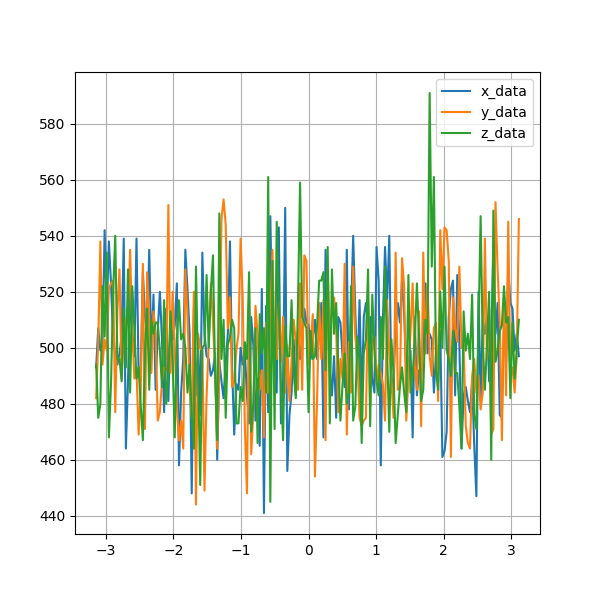

In [365]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (6,6))


plt.plot(data_label,x_data_distribution,label='x_data')
plt.plot(data_label,y_data_distribution,label='y_data')
plt.plot(data_label,z_data_distribution,label='z_data')

plt.grid(True)
plt.legend(loc=0)





<IPython.core.display.Javascript object>


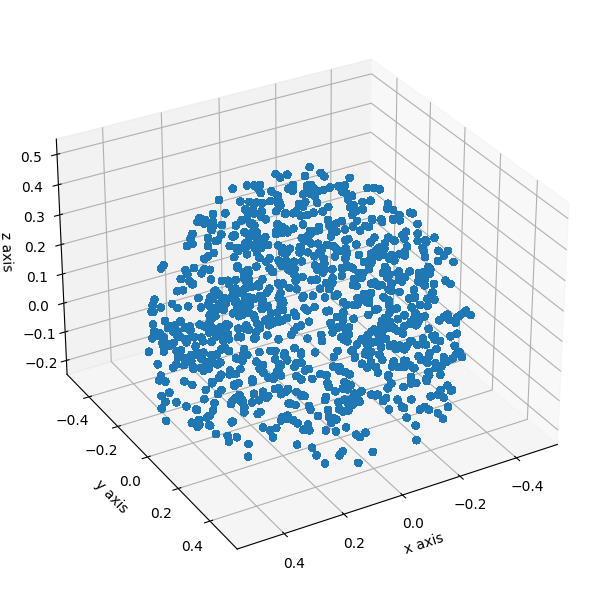

In [124]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

x = robot.position_sample

X = np.tile(x[500:1500,0],(len(x[:1000,0]),1))
Y = np.tile(x[500:1500,1],(len(x[:1000,1]),1))
Z = np.tile(x[500:1500,2],(len(x[:1000,2]),1))
ax.scatter(X,Y,Z)

ax.view_init(30,60)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

plt.tight_layout()
plt.show()

In [235]:
np.sum(np.where( (robot.position_sample[:,0]> 0.2) & (robot.position_sample[:,0] < 0.2+0.005) & (robot.position_sample[:,1]>0.1+0.1 ) ,1,0))

343

In [406]:
len(position_)

199999

<IPython.core.display.Javascript object>


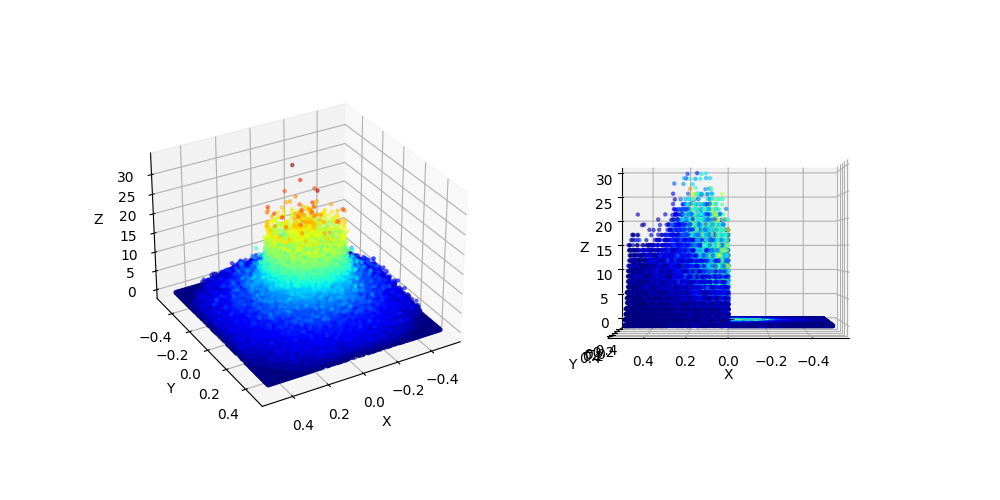

In [412]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np


fig, axs = plt.subplots(ncols=2, figsize=(10, 5), subplot_kw={"projection":"3d"})

for ax in axs:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
data_criteria = 0.005
data_label = [-0.5 + data_criteria*i for i in range(200)]

x1,y1 = np.meshgrid(data_label,data_label)
Z = np.zeros([200,200])
Z2 = np.zeros([200,200])

position = position_

for i_,i in enumerate(data_label):
    for j_,j in enumerate(data_label):
        count = np.sum(np.where( (position[:,0]> i) & (position[:,0] < i+0.005) & 
                               (position[:,1]<j+0.005 ) & (position[:,1] > j),1,0))
        
        Z[i_][j_] = count
        
        count = np.sum(np.where( (position[:,0]> i) & (position[:,0] < i+0.005) & 
                               (position[:,2]<j+0.005 ) & (position[:,2] > j),1,0))
        
        Z2[i_][j_] = count


#axs[0].plot_surface(x1,y1,Z,
#              cmap="jet",  alpha=0.5)

axs[0].scatter(x1, y1, Z,  # 3D scatter plot
               c=Z, cmap="jet", s=5, alpha=0.5)

axs[1].scatter(x1, y1, Z2,  # 3D scatter plot
               c=Z, cmap="jet", s=5, alpha=0.5)

axs[0].view_init(30,60)
axs[1].view_init(30,60)

plt.show()

In [415]:

axs[0].view_init(30,60)
axs[1].view_init(0,90)

plt.show()

In [520]:
output_ = output_.numpy()

In [521]:
position_ = position.numpy()

In [522]:
output_ = output_[np.where(position_[:,2]>0)]

In [523]:
position_ = position_[np.where(position[:,2]>0)]

In [461]:
print(len(position_))
print(len(output_))

conf = output_[:,0]

3645
3645


In [458]:
output_.shape

(3645, 6)

In [2]:
for i in range(3,6):
    print(i)

3
4
5


In [476]:
output_[:10]

array([[ 2.38037512,  1.16691985,  2.67647335,  1.73553485,  1.22160967,
        -2.53256806],
       [-1.40728816, -1.30195967, -2.81285022,  1.33193462, -2.28293247,
         0.03579678],
       [ 0.75096501, -2.5665694 ,  2.88223233,  1.79687593,  0.88816396,
        -0.73177965],
       [-0.99435003,  1.7848672 ,  2.30407206, -2.97677717,  0.45667596,
        -0.98441465],
       [-2.6291791 , -1.52430682,  3.11454731,  2.27863262, -2.83984978,
        -2.81350526],
       [-0.92406784,  0.28024575,  2.52068901, -1.83598553, -0.57994098,
         0.63019506],
       [ 1.08094411,  1.29692154,  3.05051377,  1.08271664,  1.81730704,
        -0.52987972],
       [-1.72722947,  2.94589035,  2.35038819,  2.60972596,  1.61896445,
         2.22186522],
       [ 0.25700178,  0.34478925, -2.57893456, -2.71404937, -0.13973313,
        -0.21136469],
       [ 1.71568439, -2.23841414,  0.7027704 ,  1.30147308, -2.61343322,
         0.22972497]])

In [474]:
conf[tf.where((output_[:,0]>0) & (output_[:,2]>0) & (output_[:,4]>0))] = 80
conf[tf.where((output_[:,0]>0) & (output_[:,2]>0) & (output_[:,4]<0))] = 70
conf[tf.where((output_[:,0]>0) & (output_[:,2]<0) & (output_[:,4]>0))] = 60
conf[tf.where((output_[:,0]>0) & (output_[:,2]<0) & (output_[:,4]<0))] = 50
conf[tf.where((output_[:,0]<0) & (output_[:,2]>0) & (output_[:,4]>0))] = 40
conf[tf.where((output_[:,0]<0) & (output_[:,2]>0) & (output_[:,4]<0))] = 30
conf[tf.where((output_[:,0]<0) & (output_[:,2]<0) & (output_[:,4]>0))] = 20
conf[tf.where((output_[:,0]<0) & (output_[:,2]<0) & (output_[:,4]<0))] = 10

In [481]:
len(np.where((output_[:,0]>0) & (output_[:,2]<0) & (output_[:,4]<0))[0])

443

In [378]:
axs[0].plot_surface(x1,y1,Z,
              cmap="inferno",  alpha=0.5)

axs[1].scatter(x1, y1, Z,  # 3D scatter plot
               c=Z, cmap="jet", s=5, alpha=0.5)

axs[0].view_init(30,60)
axs[1].view_init(30,60)

plt.show()

In [420]:
len(position_)
conf = position_[:,0]

len(conf)

145107

In [ ]:
c_1 = np.where( )

In [62]:
from math import pi
from math import cos 
from math import sin as sin
from math import atan2 as atan2
from math import acos as acos
from math import asin as asin
from math import sqrt as sqrt
from math import pi as pi
from numpy.linalg import norm

d = mat([0.1519, 0,0 ,0.11235,0.08535,0.0819]) #ur3 m
a =mat([0 ,-0.24365 ,-0.21325 ,0 ,0 ,0]) #ur3 cm
alpha = mat([pi/2, 0, 0, pi/2, -pi/2, 0 ]) # ur3 rad

def AH_tf(n,th):
    size = len(th.T)
    print(size)
    s = tf.sin(th)
    c = tf.cos(th)
    T_a = tf.eye(4)
    T_a[0,3] = a[0,n-1]
    T_d = tf.eye(4)
    T_d[2,3] = d[0,n-1]

    Rzt = np.array[[c(th[n-1]), -s(th[n-1]), 0 ,0],
            [np.sin(th[n-1]),  np.cos(th[n-1]), 0, 0],
            [0,               0,              1, 0],
            [0,               0,              0, 1]]


    Rxa = [[1, 0,                 0,                  0],
             [0, np.cos(alpha[0,n-1]), -np.sin(alpha[0,n-1]),   0],
             [0, np.sin(alpha[0,n-1]),  np.cos(alpha[0,n-1]),   0],
             [0, 0,                 0,                  1]]

    A_i = T_d * Rzt * T_a * Rxa
    return A_i

def HTrans_tf(th ):  
    A_1=AH_tf( 1,th )
    A_2=AH_tf( 2,th )
    A_3=AH_tf( 3,th )
    A_4=AH_tf( 4,th )
    A_5=AH_tf( 5,th )
    A_6=AH_tf( 6,th )

    T_06=A_1*A_2*A_3*A_4*A_5*A_6

    return T_06

In [21]:
# 이전 버전 
print(HTrans_tf(th,0))
print(HTrans_tf(th,1))


[[ 0.24796113 -0.83133295 -0.49739402 -0.23261216]
 [-0.89147593  0.00515721 -0.4530387  -0.18403386]
 [ 0.37919116  0.55575078 -0.73983453 -0.31553973]
 [ 0.          0.          0.          1.        ]]
[[ 0.05994036 -0.70591165  0.7057591   0.03357451]
 [-0.05384515 -0.70828752 -0.70386753 -0.29174324]
 [ 0.99674864  0.00418837 -0.08046492 -0.21318855]
 [ 0.          0.          0.          1.        ]]


In [12]:
import tensorflow as tf
import numpy as np


mat=np.matrix

a = np.identity(4)

tf.identity(a)


<tf.Tensor: shape=(4, 4), dtype=float64, numpy=
array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])>

In [90]:
th = np.array([[0.17, 0.78, 0.257, -0.12, 1.2, 0.157],
               [0.97, 0.28, 1.257, -1.12, 0.2, 1.157]])
th

array([[ 0.17 ,  0.78 ,  0.257, -0.12 ,  1.2  ,  0.157],
       [ 0.97 ,  0.28 ,  1.257, -1.12 ,  0.2  ,  1.157]])

In [63]:
print(HTrans_tf(th))

2


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [75]:
ones = tf.repeat(tf.reshape(0., (1)), 10, 0) 
ones

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [196]:
class FKc:
    def __init__(self, bs):
        self.batch_size = bs

        self.d1 = 0.1519 # unit : [m]
        self.a2 = -0.24365
        self.a3 = -0.213258
        self.d4 = 0.11235
        self.d5 = 0.08535
        self.d6 = 0.0819

        self.identity_flattened = tf.repeat(tf.reshape(tf.eye(4), (1, 16)), self.batch_size, 0) 
        
        self.zeros = tf.repeat(tf.reshape(0., (1)), self.batch_size, 0) 
        self.ones = tf.repeat(tf.reshape(1., (1)), self.batch_size, 0) 
        self.pi_2 = tf.repeat(tf.reshape(pi/2, (1)), self.batch_size, 0) 
        
        self.d1_batch = tf.repeat([self.d1], self.batch_size,0)
        self.a2_batch = tf.repeat([self.a2], self.batch_size,0)
        self.a3_batch = tf.repeat([self.a3], self.batch_size,0)
        self.d4_batch = tf.repeat([self.d4], self.batch_size,0)
        self.d5_batch = tf.repeat([self.d5], self.batch_size,0)
        self.d6_batch = tf.repeat([self.d6], self.batch_size,0)
        
        self.d_ = [self.d1_batch, self.zeros,self.zeros ,self.d4_batch,self.d5_batch,self.d6_batch] #ur3 m
        self.a_ =[self.zeros ,self.a2_batch ,self.a3_batch ,self.zeros ,self.zeros ,self.zeros] #ur3 cm
        self.alpha_ = [self.pi_2, self.zeros, self.zeros, self.pi_2, -self.pi_2, self.zeros] # ur3 rad
        
    def FK(self, angles):
        pos = tf.reshape(tf.constant([0, 0, 0, 1], dtype=float), (4, 1))
        s = tf.sin(angles)
        c = tf.cos(angles)
        # T1 = [sp.cos(q0), 0, sp.sin(q0), 0, 0, 1, 0, 0, -sp.sin(q0), 0, sp.cos(q0), 0, 0, 0, 0, 1
        
    def AH_tf(self,n,th):   

        s_t = tf.sin(th[:,n-1])
        c_t = tf.cos(th[:,n-1])
        
        s_a = tf.sin(self.alpha_[n-1])
        c_a = tf.cos(self.alpha_[n-1])
        
        s_t = tf.cast(s_t,tf.float32)
        c_t = tf.cast(c_t,tf.float32)

        #A_i = [c_t, -c_a*s_t, s_a*s_t,l*c_t,
        #      s_t, c_a*c_t, -s_a*c_t, l*s_t,
        #      0, s_a, c_a, d
        #      0, 0, 0, 1]
        A_ = [c_t, -c_a*s_t, s_a*s_t, self.a_[n-1]*c_t,
              s_t, c_a*c_t, -s_a*c_t, self.a_[n-1]*s_t,
              self.zeros, s_a, c_a, self.d_[n-1],
              self.zeros,self.zeros,self.zeros,self.ones]
        A_ = tf.reshape(tf.stack(A_, axis=1), (self.batch_size, 4, 4))
        return A_

    def HTrans_tf(self,th ):  
        #th= tf.convert_to_tensor(th)
        #th= tf.transpose(th)
        A_1=self.AH_tf( 1,th )
        A_2=self.AH_tf( 2,th )
        A_3=self.AH_tf( 3,th )
        A_4=self.AH_tf( 4,th )
        A_5=self.AH_tf( 5,th )
        A_6=self.AH_tf( 6,th )
    
        A_ = tf.matmul(A_1,A_2)
        A_ = tf.matmul(A_,A_3)
        A_ = tf.matmul(A_,A_4)
        A_ = tf.matmul(A_,A_5)
        A_ = tf.matmul(A_,A_6)

        return A_

In [199]:
fk = FKc(2)
fk.a_[1]
th
x_ = tf.sin(fk.alpha_[n-1])
y_ = tf.cos(th[:,n-1])

th_ = fk.HTrans_tf(th)


th

array([[ 0.17 ,  0.78 ,  0.257, -0.12 ,  1.2  ,  0.157],
       [ 0.97 ,  0.28 ,  1.257, -1.12 ,  0.2  ,  1.157]])

In [198]:
th_

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[ 0.24796116, -0.8313331 , -0.49739408, -0.2326162 ],
        [-0.891476  ,  0.00515716, -0.4530387 , -0.18403453],
        [ 0.37919113,  0.5557508 , -0.7398346 , -0.31554663],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.05994041, -0.7059117 ,  0.7057591 ,  0.03357436],
        [-0.05384517, -0.7082876 , -0.70386755, -0.29174346],
        [ 0.9967487 ,  0.00418845, -0.08046497, -0.21319658],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]],
      dtype=float32)>

In [186]:
tf.math.multiply(s_t, s_a)


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.16918235, 0.8248857 ], dtype=float32)>

In [ ]:
def fk_mean_dist(ans,pred):
    pred = tf.convert_to_tensor(pred)
    ans = tf.cast(ans, pred.dtype)
    pred_fk = robot.HTrans_tf(pred)
    ans_fk = robot.HTrans_tf(ans)
    dist = tf.sqrt(tf.reduce_sum(tf.square(ans_fk-pred_fk),axis=1))[:,3]
    return tf.reduce_sum(dist)


def fk_above_1cm_dist(ans,pred):
    pred = tf.convert_to_tensor(pred)
    ans = tf.cast(ans, pred.dtype)

    pred_fk = robot.HTrans_tf(pred)
    ans_fk = robot.HTrans_tf(ans)
    dist = tf.sqrt(tf.reduce_sum(tf.square(ans_fk-pred_fk),axis=1))[:,3]
    above_1cm = tf.reduce_sum(tf.cast(dist>1.e-2, tf.float32))
    return above_1cm/(robot_model.batch_size)*100


def fk_above_1mm_dist(ans,pred):
    pred = tf.convert_to_tensor(pred)
    ans = tf.cast(ans, pred.dtype)
    pred_fk = robot.HTrans_tf(pred)
    ans_fk = robot.HTrans_tf(ans)

    dist = tf.sqrt(tf.reduce_sum(tf.square(ans_fk-pred_fk),axis=1))[:,3]
    above_1mm = tf.reduce_sum(tf.cast(dist>1.e-3, tf.float32))
    
    return above_1mm/(robot.batch_size)*100
val_loss_name = os.path.join('checkpoint', robot_model.model_name,'val_loss',"{name}_loss.h5".format(name=robot_model.model_name))
val_1mm_name = os.path.join('checkpoint', robot_model.model_name,'val_1mm_above',"{name}_1mm.h5".format(name=robot_model.model_name))
val_1cm_name = os.path.join('checkpoint', robot_model.model_name,'val_1cm_above',"{name}_1cm.h5".format(name=robot_model.model_name))

from tensorflow.keras.optimizers import Nadam
log_dir = "logs/" + robot_model.model_name + '_' + dt.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
#val_loss_chkpt = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('checkpoints', robot_model.model_name,'val_loss',''),
#                                                        monitor='val_loss', save_best_only=True, verbose=False)
val_loss_chkpt = tf.keras.callbacks.ModelCheckpoint(val_loss_name,
                                                        monitor='val_loss', save_best_only=True, verbose=False)
val_1cm_chkpt = tf.keras.callbacks.ModelCheckpoint(val_1cm_name,
                                                       monitor='val_fk_above_1cm_dist', save_best_only=True, verbose=False)
val_1mm_chkpt = tf.keras.callbacks.ModelCheckpoint(val_1mm_name,
                                                       monitor='val_fk_above_1mm_dist', save_best_only=True, verbose=False)

def scheduler(epoch, lr):
    lr_ = lr*tf.math.exp(-0.1*epoch/150)
    print(lr_)
    if lr_> 1e-6:
        return lr*tf.math.exp(-0.1*epoch/150)
    else:
        return 1e-6
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stopping =EarlyStoppingWMinEpoch(monitor='val_fk_above_1mm_dist', min_delta=0.05, patience=110,  earliest_epoch=750)

### Optimizer ###
lr_init = 0.01
opt = tf.keras.optimizers.Nadam(learning_rate=lr_init)


In [ ]:
scheduler